# Illustration of feature preprocessing for MovieLens dataset
<blockquote>
    <p>The feature generation shown below is placed in the <a href="https://github.com/AlgoMathITMO/sber-simulator/blob/experiments-new/experiments/Movielens/ml20.py" title="ml20.py">file</a>, 
        and is done together with the splitting of the data for later use in the experiments in the 
        <a href="https://github.com/AlgoMathITMO/sber-simulator/blob/experiments-new/experiments/Movielens/traint_test_split.ipynb" title="traint_test_split.ipynb">notebook</a>.</p>
</blockquote>

### $\textbf{𝐓𝐚𝐛𝐥𝐞 𝐨𝐟 𝐂𝐨𝐧𝐭𝐞𝐧𝐭𝐬}$:

### $\textbf{I. Film processing}$
### The following attributes are generated from the film titles and their genres:
#### - film release year $\it{year} \in \mathbb{N}$;
#### - film genre $\it{genre}=\{\it{genre}_i\}_{i=0}^{18} \in \{0, 1\}^{19}$;
### The following attributes are generated from the film ratings:
#### - average rating of the film $\it{rating\_avg} \in \mathbb{R}^+$;


---

### $\textbf{II. Tag processing}$
### The following attributes are generated from text descriptions, tags that the users have left for the films:
#### - Average of vector representations of film tags $\it{w2v}=\{\it{w2v}_i\}_{i=0}^{299} \in \mathbb{R}^{300}$;

---

### $\textbf{III. User processing}$
#### Since users do not have their own attributes in the dataset, the attributes for them are the aggregated attributes of the films they rated
### The following user attributes are generated from the film attributes $\{\it{w2v}, \it{genre}\}$
#### - average of the genres of films rated by the user $\it{genre}=\{\it{genre}_i\}_{i=0}^{18} \in \{0, 1\}^{19}$;
#### - average of vector representations of film tags rated by the user $\it{w2v}=\{\it{w2v}_i\}_{i=0}^{299} \in \mathbb{R}^{300}$;
### The following attributes are generated from the film ratings:
#### - average rating given by the user $\it{rating\_avg} \in \mathbb{R}^+$;

---
---

In [ ]:
import pandas as pd
import numpy as np
import re
import itertools
import tqdm

import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MOVIE_PATH = r'./data_row/movies.csv'
RATING_PATH = r'./data_row/ratings.csv'
TAG_PATH = r'./data_row/tags.csv'

In [3]:
def title_prep(title):
    
    """
    The function of cleaning the title of the movie from extra spaces, reduction to lowercase.ch of methods to create
    vector embeddings from original data

    :param title: the title of the movie
    :type title: str
    :return: cleaned title of the movie
    :rtype: str
    """
    title = re.sub(r'\s+', r' ', title)
    title = re.sub(r'($\s+|^\s+)', '', title)
    title = title.lower()
    
    return title

def extract_year(title):
    
    """
    Extracting year from the movie title

    :param title: the cleaned title of the movie
    :type title: str
    :return: movie year
    :rtype: float, optional
    """
    
    one_year = re.findall(r'\(\d{4}\)', title)
    two_years = re.findall(r'\(\d{4}-\d{4}\)', title)
    one_year_till_today = re.findall(r'\(\d{4}[-–]\s?\)', title)
    if len(one_year) == 1:
        return int(one_year[0][1:-1])
    
    elif len(two_years) == 1:
        return round((int(two_years[0][1:5]) + int(two_years[0][6:-1]))/2)
    
    elif len(one_year_till_today) == 1:
        return int(one_year_till_today[0][1:5])
    else:
        return np.nan

In [4]:
def genres_processing(movies):   
    
    """
    Processing movie genres by constructing a binary vector of length n, where n is the number of all possible genres.
    For example a string like 'genre1|genre3|...' will be transformed into a vector [0,1,0,1,...].

    :param movies: DataFrame with column 'genres'
    :type title: pd.DataFrame
    :return: DataFrame with processed genres
    :rtype: pd.DataFrame
    """
    
    genre_lists = [set(item.split('|')).difference(set(['(no genres listed)'])) for item in movies['genres']]
    genre_lists = pd.DataFrame(genre_lists)
    
    genre_dict = {token: idx for idx, token in enumerate(set(itertools.chain.from_iterable([item.split('|') 
                for item in movies['genres']])).difference(set(['(no genres listed)'])))}
    genre_dict = pd.DataFrame(genre_dict.items())
    genre_dict.columns = ['genre', 'index']
    
    dummy = np.zeros([len(movies), len(genre_dict)])
    
    for i in range(dummy.shape[0]):
        for j in range(dummy.shape[1]):
            if genre_dict['genre'][j] in list(genre_lists.iloc[i, :]):
                dummy[i, j] = 1
    
    df_dummy = pd.DataFrame(dummy, columns = ['genre' + str(i) for i in range(dummy.shape[1])])
    
    movies_return = pd.concat([movies, df_dummy], 1)
    return movies_return

In [5]:
def fill_null_years(movies):
    
    """
    Processing null years

    :param movies: DataFrame with processed years
    :type title: pd.DataFrame
    :return: DataFrame with processed not null years
    :rtype: pd.DataFrame
    """
    
    
    df_movies = movies.copy()
    genres_columns = [item for item in movies.columns.tolist() if item[:5]=='genre' and item !='genres']
    df_no_year = movies[movies.year.isna()][['movieId', *genres_columns]]

    years_mean = {}
    for i in df_no_year.index:
    
        row = np.asarray(df_no_year.loc[i, :][genres_columns])
        years = []
        for j in np.asarray(movies[['year', *genres_columns]]):
            if np.sum(row == j[1:]) == len(genres_columns):
                try:
                    years.append(int(j[0]))
                except:
                    pass
            
        years_mean[i] = round(np.mean(years))
    
    for i in years_mean:
        df_movies.loc[i, 'year'] = years_mean[i]
    
    df_movies.year=df_movies.year.astype('int')
    
    return df_movies

### I. Film processing

In [6]:
df_movie = pd.read_csv(MOVIE_PATH)
df_movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_rating = pd.read_csv(RATING_PATH)
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


#### Generation of features - year and genres 

In [8]:
df_movies_procc = df_movie.copy()
df_movies_procc.title = df_movies_procc.title.apply(title_prep)
df_movies_procc['year'] = df_movies_procc.title.apply(extract_year)
df_movies_procc.head()

,movieId,title,genres,year
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,grumpier old men (1995),Comedy|Romance,1995.0
3,4,waiting to exhale (1995),Comedy|Drama|Romance,1995.0
4,5,father of the bride part ii (1995),Comedy,1995.0


In [9]:
df_movies_procc = genres_processing(df_movies_procc)
df_movies_procc = fill_null_years(df_movies_procc)
df_movies_procc.head()

,movieId,title,genres,year,genre0,genre1,genre2,genre3,genre4,genre5,...,genre9,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18
0,1,toy story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,jumanji (1995),Adventure|Children|Fantasy,1995,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,grumpier old men (1995),Comedy|Romance,1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,waiting to exhale (1995),Comedy|Drama|Romance,1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,father of the bride part ii (1995),Comedy,1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Generating a feature - average film score and removing unnecessary columns

In [16]:
df_movies_procc = pd.merge(df_movies_procc, 
                           df_rating.groupby('movieId', as_index=False).rating.mean(), on='movieId', how='left')

df_movies_procc.rating = df_movies_procc.rating.fillna(0.0)
df_movies_procc = df_movies_procc.rename(columns={'rating' : 'rating_avg'})
df_movies_clean = df_movies_procc.drop(['title', 'genres'], axis=1)[['movieId', 'year', 'rating_avg', *['genre' + str(i) for i in range(19)]]]

df_movies_clean.head()

,movieId,year,rating_avg,genre0,genre1,genre2,genre3,genre4,genre5,genre6,...,genre9,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18
0,1,1995,3.921240,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1995,3.211977,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,1995,3.151040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1995,2.861393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,1995,3.064592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


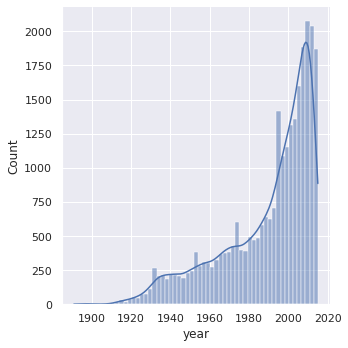

In [17]:
plt.rcParams["figure.figsize"] = (15,10)
sns.set(rc={'figure.figsize':(15,10)})

sns.displot(df_movies_clean.year, kde=True)

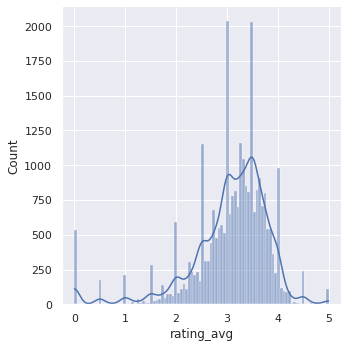

In [18]:
sns.displot(df_movies_clean.rating_avg, kde=True)

### II. Tag processing

In [19]:
df_tags = pd.read_csv(TAG_PATH)
df_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [20]:
df_tags = df_tags.drop(df_tags[df_tags.tag.isna()].index)
df_movie_tags = df_tags.sort_values(by=['movieId', 'timestamp'])[['movieId', 'tag', 'timestamp']]
df_movie_tags.head()

,movieId,tag,timestamp
215683,1,the boys,1137115175
286458,1,classic,1137117317
286459,1,pixar,1137117317
344045,1,Disney,1137170413
325966,1,pixar,1137206825


In [21]:
from bs4 import BeautifulSoup

from nltk.tokenize import TreebankWordTokenizer, WhitespaceTokenizer

import nltk
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
words = set([w.lower() for w in words])

from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("wordnet")

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))


from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/agurov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /data/home/agurov/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /data/home/agurov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def clean_text(text):
    """
    Cleaning text: remove extra spaces and non-text characters

    :param text: tag row text
    :type title: str
    :return: tag cleaned text
    :rtype: str
    """
    
    text = re.sub("[^a-zA-Z]", " ",text)

    text = re.sub(r"\s+", " ", text)

    text = re.sub(r"\s+$", "", text)
    text = re.sub(r"^\s+", "", text)

    text = text.lower()

    return text


def procces_text(text):
    
    """
    Processing text: lemmatization, tokenization, removing stop-words

    :param text: tag cleaned text
    :type title: str
    :return: tag processed text
    :rtype: str
    """
    
    lemmatizer = WordNetLemmatizer() #lemmatization

    text = [word for word in nltk.word_tokenize(text) if not word in stop_words]
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [word for word in text if word in words]

    text = " ".join(text)
    
    return text

### Tag processing and concatenation

In [23]:
df_movie_tags['clean_tag'] = df_movie_tags.tag.apply(lambda x : procces_text(clean_text(x)))
df_movie_tags.head()

,movieId,tag,timestamp,clean_tag
215683,1,the boys,1137115175,boy
286458,1,classic,1137117317,classic
286459,1,pixar,1137117317,
344045,1,Disney,1137170413,
325966,1,pixar,1137206825,


In [24]:
df_movie_tags.isna().sum()

movieId      0
tag          0
timestamp    0
clean_tag    0
dtype: int64

In [26]:
len(df_movie_tags[df_movie_tags.clean_tag.str.len()!=0].movieId.unique()) / len(df_movie_tags.movieId.unique()) 

#number of films with a non-zero tag

0.9547135971303665

In [27]:
df_movie_tags = df_movie_tags[df_movie_tags.clean_tag.str.len()!=0]
df_movie_tags.head()

,movieId,tag,timestamp,clean_tag
215683,1,the boys,1137115175,boy
286458,1,classic,1137117317,classic
140301,1,animation,1137316553,animation
142972,1,rated-G,1137424344,rated g
274212,1,buy,1137440588,buy


In [28]:
docs_movie_tags = df_movie_tags.sort_values(["movieId", "timestamp"]).groupby("movieId", as_index=False).agg({"clean_tag":lambda x: " ".join(x)})
docs_movie_tags.head()

,movieId,clean_tag
0,1,boy classic animation rated g buy adventure an...
1,2,monkey child game animal flick child fantasy r...
2,3,movie sequel fever de ada old moldy jack walte...
3,4,chick flick revenge character character chick ...
4,5,family sequel wedding pregnancy remake sequel ...


### Tag vectorisation

In [29]:
import gensim
from gensim.downloader import load
from gensim.models import Word2Vec

In [30]:
w2v_model = gensim.downloader.load('word2vec-google-news-300')

In [31]:
def string_to_avg_vec(string):
    """
    Processing text: lemmatization, tokenization, removing stop-words

    :param string: cleaned and processed tags
    :type title: str
    :return: average vector of the string words embeddings
    :rtype: np.ndarray, optional
    """
    
    arr = string.split(' ')
    vec = 0
    cnt = 0
    for i in arr:
        try:
            vec += w2v_model[i]
            cnt += 1
        except:
            pass
    if cnt == 0:
        vec = np.zeros((300, 1))
    else:
        vec /= cnt
    return vec

In [32]:
vect_space = np.empty((docs_movie_tags.shape[0], 300))
for i in range(docs_movie_tags.shape[0]):
    vect_space[i] = string_to_avg_vec(docs_movie_tags.iloc[i, 1]).T

In [35]:
for i in range(300):
    docs_movie_tags['w2v_' + str(i)] = vect_space[:, i]
docs_movie_tags.drop('clean_tag', axis=1, inplace=True)

docs_movie_tags.head()

,movieId,clean_tag,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
0,1,boy classic animation rated g buy adventure an...,0.068727,0.014178,0.005185,0.150069,-0.045132,-0.019740,0.042479,-0.057705,...,-0.174128,0.101186,-0.124264,-0.065017,-0.008562,-0.016978,0.010792,-0.054439,-0.050692,0.008655
1,2,monkey child game animal flick child fantasy r...,0.035116,0.069810,-0.050003,0.113316,0.041066,-0.034437,0.019555,-0.042539,...,-0.103736,0.070565,-0.028863,-0.006904,0.037426,-0.010059,-0.008811,0.043633,0.033821,0.033346
2,3,movie sequel fever de ada old moldy jack walte...,0.076245,-0.004556,0.035275,0.094739,-0.051540,0.042352,-0.015326,-0.067964,...,-0.076153,0.123608,-0.064561,0.027002,0.005661,-0.037820,-0.074014,-0.057489,0.007660,0.074479
3,4,chick flick revenge character character chick ...,0.101859,-0.033831,-0.157410,0.112095,-0.018066,0.169155,0.103707,-0.093471,...,-0.097569,0.272740,-0.243025,-0.073382,-0.077218,-0.048793,0.043527,-0.133022,-0.110073,0.114049
4,5,family sequel wedding pregnancy remake sequel ...,0.029992,0.014367,-0.103588,0.204794,-0.084839,-0.022625,-0.020145,-0.075674,...,-0.125023,0.066525,-0.080285,0.032828,0.004620,-0.037645,-0.135221,-0.099760,0.002582,0.080562


In [36]:
df_movies_clean = pd.merge(df_movies_clean, docs_movie_tags, on='movieId', how='left')
df_movies_clean = df_movies_clean.fillna(0.0)
df_movies_clean.head()

,movieId,year,rating_avg,genre0,genre1,genre2,genre3,genre4,genre5,genre6,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
0,1,1995,3.921240,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.174128,0.101186,-0.124264,-0.065017,-0.008562,-0.016978,0.010792,-0.054439,-0.050692,0.008655
1,2,1995,3.211977,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-0.103736,0.070565,-0.028863,-0.006904,0.037426,-0.010059,-0.008811,0.043633,0.033821,0.033346
2,3,1995,3.151040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.076153,0.123608,-0.064561,0.027002,0.005661,-0.037820,-0.074014,-0.057489,0.007660,0.074479
3,4,1995,2.861393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.097569,0.272740,-0.243025,-0.073382,-0.077218,-0.048793,0.043527,-0.133022,-0.110073,0.114049
4,5,1995,3.064592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.125023,0.066525,-0.080285,0.032828,0.004620,-0.037645,-0.135221,-0.099760,0.002582,0.080562


In [233]:
df_movies_clean.to_csv(r'./data_clean/movie_clean_.csv', index=False)

### III. User processing

In [38]:
df_users = df_rating.copy()
df_users.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


### Generation of the average rating given by the user

In [39]:
df_users = df_users.groupby(by=['userId'], as_index=False).rating.mean().rename(columns = {'rating' : 'rating_avg'})
df_users.head()

,userId,rating_avg
0,1,3.742857
1,2,4.000000
2,3,4.122995
3,4,3.571429
4,5,4.272727


### Aggregation of film genres rated by users

In [40]:
df_users_genres = pd.merge(df_movies_clean[['movieId', *df_movies_clean.columns[3:22]]], pd.merge(df_rating, df_users, on = 'userId')[['userId', 'movieId']],
        on = 'movieId')

df_users_genres = df_users_genres.groupby(by = ['userId'], as_index = False)[df_movies_clean.columns[3:22]].mean()
df_users_genres = pd.merge(df_users_genres, df_users, on = 'userId')

df_users_genres.head()

,userId,genre0,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,...,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18,rating_avg
0,1,0.022857,0.057143,0.394286,0.108571,0.051429,0.000000,0.011429,0.377143,0.000000,...,0.228571,0.234286,0.120000,0.240000,0.017143,0.257143,0.245714,0.102857,0.417143,3.742857
1,2,0.032787,0.016393,0.016393,0.016393,0.065574,0.016393,0.016393,0.311475,0.000000,...,0.377049,0.163934,0.016393,0.311475,0.032787,0.295082,0.311475,0.065574,0.278689,4.000000
2,3,0.016043,0.021390,0.106952,0.053476,0.032086,0.005348,0.000000,0.326203,0.005348,...,0.497326,0.278075,0.112299,0.267380,0.032086,0.171123,0.310160,0.058824,0.267380,4.122995
3,4,0.035714,0.071429,0.107143,0.142857,0.035714,0.000000,0.000000,0.464286,0.000000,...,0.178571,0.392857,0.214286,0.464286,0.071429,0.000000,0.285714,0.107143,0.214286,3.571429
4,5,0.030303,0.090909,0.166667,0.166667,0.015152,0.000000,0.045455,0.272727,0.000000,...,0.151515,0.363636,0.106061,0.227273,0.121212,0.015152,0.409091,0.030303,0.318182,4.272727


In [41]:
df_pairs = pd.merge(df_rating, df_users, on = 'userId')[['userId', 'movieId']]
df_pairs.head()

,userId,movieId
0,1,2
1,1,29
2,1,32
3,1,47
4,1,50


### Aggregation of vector representations of user-rated film tags

In [ ]:
users_id = []
vect_space = []

for Id in tqdm.tqdm(df_pairs.userId.unique()):
    movie_list = df_pairs[df_pairs.userId == Id].movieId.tolist()
    
    vect = np.asarray(df_movies_clean[df_movies_clean.movieId.isin(movie_list)][[*df_movies_clean.columns[22:]]].mean().tolist())
    users_id.append(Id)
    vect_space.append(vect)

 51%|█████     | 70482/138493 [1:14:54<1:04:03, 17.69it/s]

In [ ]:
df_users_w2v = pd.DataFrame(vect_space, columns = ['w2v_' + str(i) for i in range(len(df_movies_clean.columns[22:]))])
df_users_w2v['userId'] = users_id
df_users_w2v.head()

In [ ]:
users_full = pd.merge(df_users_genres, df_users_w2v, on = 'userId')
users_full.head()

In [245]:
users_full.to_csv(r'./data_clean/user_clean.csv', index=False)

In [246]:
df_rating = df_rating[['userId', 'movieId', 'rating']]
df_rating.to_csv(r'./data_clean/rating_clean.csv', index=False)